# Dibble region

Aside from doing I09S, the MISO voyage sampled waters directly off-shore on East Antarctica. This sampling showed increased oxygen continent in the bottom layers, which indicates recently ventilated bottom waters. The reasons behind this recent ventilation are yet to be pinned down, but we can start to understand the oceanography of the region by looking at the circulation of waters on the shelf in the area. 

Due to the scarcity of data, we will do this using ACCESS-OM2 model. We will start by using time-averaged velocity fields from the high resolution simulation forced with the atmosphere from 1958 to 2018. Monthly varying 3D fields are very large in size and usually require an HPC to manipulate. 

## Learning objectives
 - Using a numerical model to characterise the regional circulation.
 - Learn to identify bathymetric features.
 - Extract variables at the surface and at the ocean's bottom. 
 - Plot a velocity field with vectors.
 - Understand and interpret the "age" variable. 
 - Interpret the transport across the 1000m isobath, calculate the export and its properties in three canyons in our study region.

In [2]:
# Import libraries
import cmocean as cm
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

## Bathymetry

Let's look at the model's bathymetry of the shelf (shallower than 1000m) first. Remember that this is the model's bathymetry, and that this is an undersampled region of the ocean - so it could happen that there are unknown features of the ocean bottom missing here..

In [8]:
bathymetry = xr.open_dataarray('data/access_hu_dibble.nc')
bathymetry

<xarray.DataArray 'hu' (yu_ocean: 139, xu_ocean: 210)>
[29190 values with dtype=float32]
Coordinates:
  * xu_ocean  (xu_ocean) float64 -233.0 -232.9 -232.8 ... -212.3 -212.2 -212.1
  * yu_ocean  (yu_ocean) float64 -67.99 -67.95 -67.91 ... -62.1 -62.05 -62.01
Attributes:
    long_name:     ocean depth on u-cells
    contact:       Andrew Kiss
    ncfiles:       /g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra...
    cell_methods:  time: point
    email:         andrew.kiss@anu.edu.au
    units:         m
    coordinates:   geolon_c geolat_c
    valid_range:   [-1.e+09  1.e+09]
    notes:         Run configuration and history: https://github.com/COSIMA/0...
    created:       2020-11-11
    description:   0.1 degree ACCESS-OM2 global model configuration under int...

You can see that this time, the horizontal coordinates are `xu_ocean` and `yu_ocean` instead of `xt_ocean` and `yt_ocean`. More on that later.

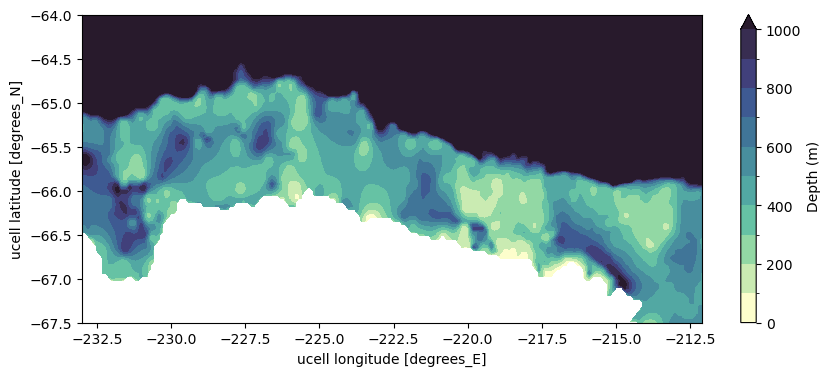

In [9]:
bathymetry.plot.contourf(figsize = (10, 4), vmin = 0, vmax = 1000, levels = 11, cmap = cm.cm.deep, cbar_kwargs = {'label':'Depth (m)'})
plt.ylim(-67.5, -64);

The longitudes in the model are in an unconventional range (-260, 80), but we can convert them easily to (-180, 180) by adding 360.

In [11]:
bathymetry['xu_ocean'] = bathymetry['xu_ocean'].values+360

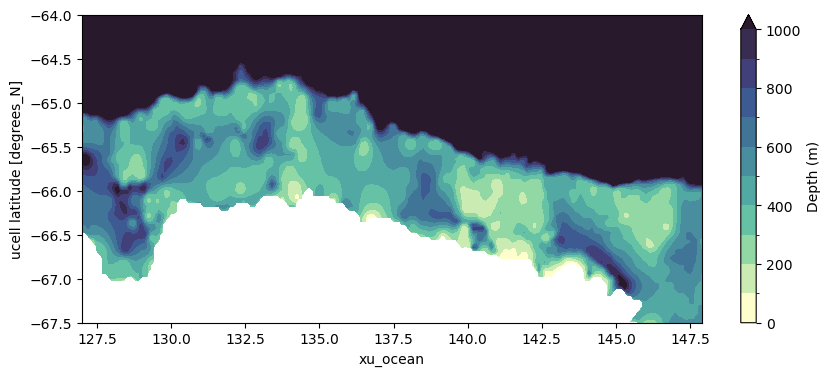

In [12]:
bathymetry.plot.contourf(figsize = (10, 4), vmin = 0, vmax = 1000, levels = 11, cmap = cm.cm.deep, cbar_kwargs = {'label':'Depth (m)'})
plt.ylim(-67.5, -64);

At around 144E you can see the deep sill of the Mertz glacier (one of the local regions of bottom water formation). **Insert any other features you wish to discuss in class**

## Surface and bottom circulation

Open velocity fields

In [14]:
u = xr.open_dataarray('data/access_u_mean_dibble.nc')
v = xr.open_dataarray('data/access_v_mean_dibble.nc')
u['xu_ocean'] = u['xu_ocean'].values+360
v['xu_ocean'] = v['xu_ocean'].values+360

In [15]:
u

<xarray.DataArray 'u' (st_ocean: 75, yu_ocean: 139, xu_ocean: 210)>
[2189250 values with dtype=float32]
Coordinates:
  * xu_ocean  (xu_ocean) float64 127.0 127.1 127.2 127.3 ... 147.7 147.8 147.9
  * yu_ocean  (yu_ocean) float64 -67.99 -67.95 -67.91 ... -62.1 -62.05 -62.01
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

You can see that this time, we also have a vertical coordinate. There is no time coordinate because you have been provided with a time average field (otherwise the data becomes hard to work with due to its size).

The surface circulation is easy. We just need to select the top-most gridcell. We use `.isel()`, which allows you to select by index instead of coordinate value.

In [17]:
u_surf = u.isel(st_ocean = 0)
v_surf = v.isel(st_ocean = 0)
# Let's also calculate the speed since we are at it
speed = np.sqrt(u_surf**2 + v_surf**2)

Let's plot this:

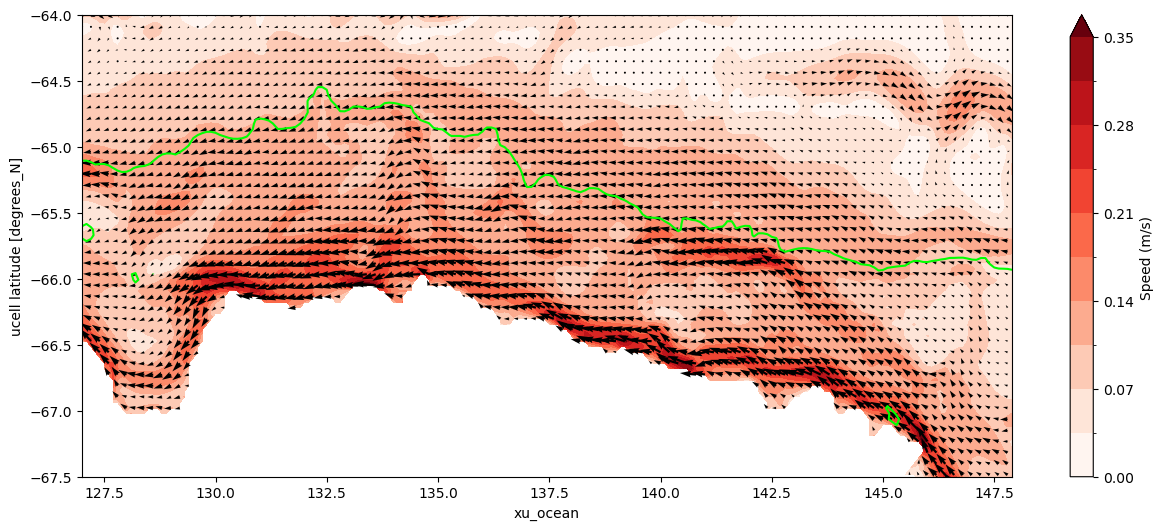

In [18]:
speed.plot.contourf(figsize = (15, 6), vmin = 0, vmax = .35, levels = 11, cmap = 'Reds', cbar_kwargs = {'label':'Speed (m/s)'})
bathymetry.plot.contour(levels = [1000], colors = ['lime'])
plt.ylim(-67.5, -64);
plt.quiver(u['xu_ocean'][::2], u['yu_ocean'][::2], u_surf[::2,::2], v_surf[::2,::2]);

The dominant circulation is a strong, westward, with a strong coastal current along the Antarctic margins.

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 40%; max-width: 250px;">
    <img src="images/bottom_selection.png" width="100%"/>
</div> 

Getting bottom properties is a bit more tricky than selecting the surface. We can't use `.isel(depth = -1)` because the bottom is at different depths in different locations (this would retrieve for us the values at the red points in the schematic on the right).

What we want are the green points! We actually need to select is the last level at which we have temperature information. And we have to do a bit of a workaround for this.

1. Create a mask that has 1s where we have data, and 0s over land.
2. Do a cumulative sum from the surface down, which will reach a maximum value once we get to the bottom and start adding 0s.
3. Select the location of the maxium of the cumulative sum
4. Evaluate our data at the location of the maximum

In [19]:
mask = xr.where(np.isnan(u), 0, 1)
mask = mask.cumsum('st_ocean')
bottom_level = mask.argmax('st_ocean')

u_bottom = u.isel(st_ocean = bottom_level)
v_bottom = v.isel(st_ocean = bottom_level)
speed_bottom = np.sqrt(u_bottom**2 + v_bottom**2)

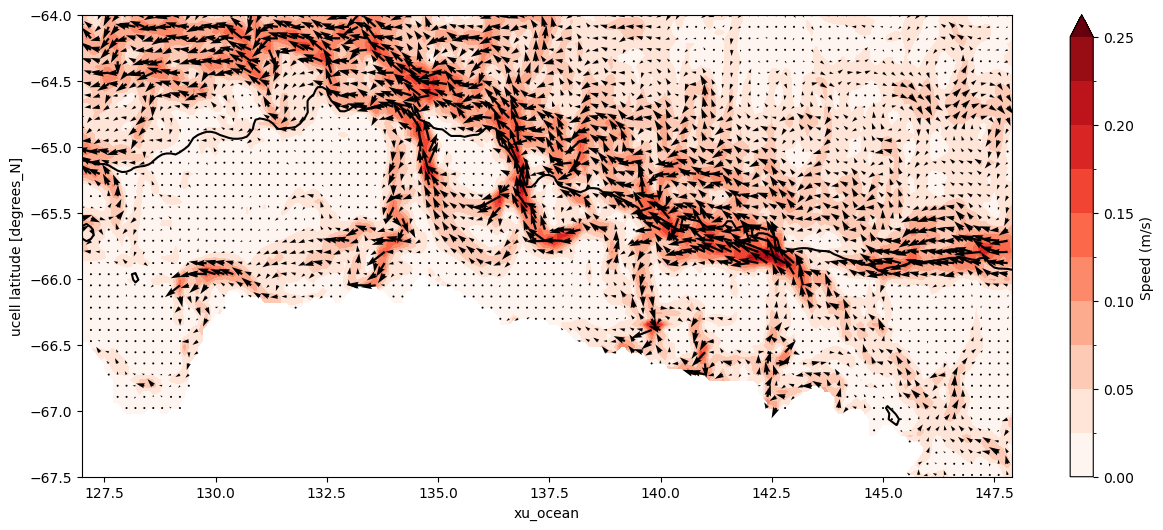

In [20]:
speed_bottom.plot.contourf(figsize = (15, 6), vmin = 0, vmax = .25, levels = 11, cmap = 'Reds', cbar_kwargs = {'label':'Speed (m/s)'})
bathymetry.plot.contour(levels = [1000], colors = ['k'])
plt.ylim(-67.5, -64);
plt.quiver(u['xu_ocean'][::2], u['yu_ocean'][::2], u_bottom[::2,::2], v_bottom[::2,::2]);

Unlike surface velocities, there is not much trace of the coastal current in the bottom flow. Off-shelf, the circulation is dominated by a strong westward current (the bottom intensified Antarctic Slope Current), whereas on the shelf, the flow seems to be oriented according to the topography.

We can check that by plotting the bottom velocity vectors on top of the bathymetry. You can see how the most intense flow is follows the contours of steep bathymetric gradients (slopes), skirting around areas of shallow topography.

Also note how the flow is directed off shore in canyons - around 134E, 136E and 143E. These are presumably the regions where bottom waters are able to escape the continental shelf.

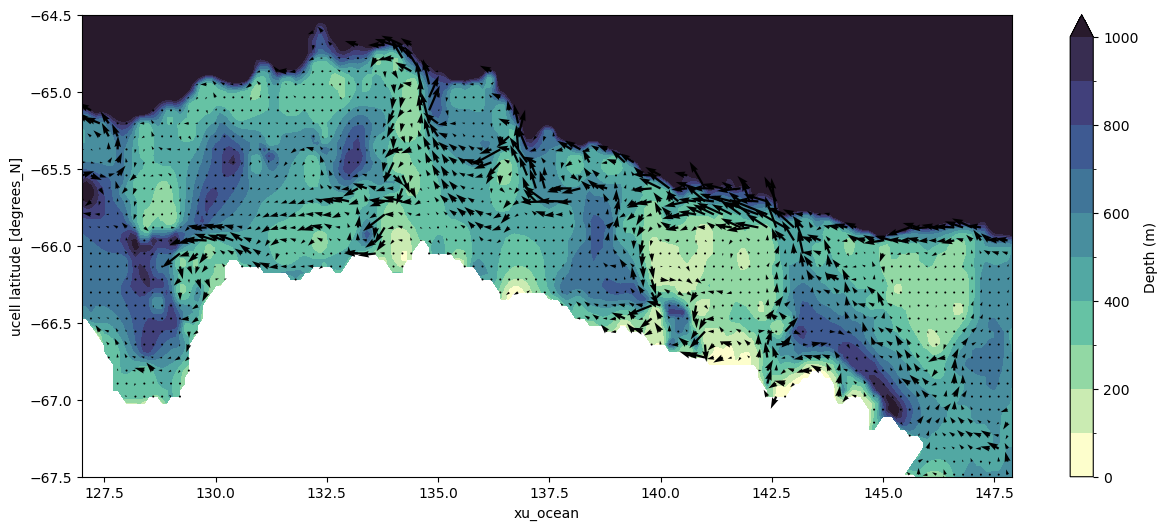

In [22]:
bathymetry.plot.contourf(figsize = (15, 6), vmin = 0, vmax = 1000, levels = 11, cmap = cm.cm.deep, cbar_kwargs = {'label':'Depth (m)'})
plt.ylim(-67.5, -64.5);
plt.quiver(u['xu_ocean'][::2], u['yu_ocean'][::2], 
           u_bottom[::2,::2].where(bathymetry<1000), v_bottom[::2,::2].where(bathymetry<1000));

## Age

A variable of interest available in model output is the "age" of a water mass, which is the amount of time the parcel has spent away from the surface. At the surface, the age will be zero everywhere. But at the bottom, age can tell us how recently that parcel was ventilated (in touch with the surface). Young waters are the bottom are synonim with recently ventilated waters - which allows us to infer bottom water formation regions.

Age is not something we can directly measure in the real ocean. However, there are tracers like CFCs which serve a similar purpose and are used in a similar way.

In [23]:
age = xr.open_dataarray('data/access_age_mean_dibble.nc')
age['xt_ocean'] = age['xt_ocean'].values+360

Let's retrieve age at the bottom:

In [24]:
mask = xr.where(np.isnan(age), 0, 1)
mask = mask.cumsum('st_ocean')
bottom_level = mask.argmax('st_ocean')

age_bottom = age.isel(st_ocean = bottom_level)

Let's plot age with velocity contours again, and the 1000m isobath in green.

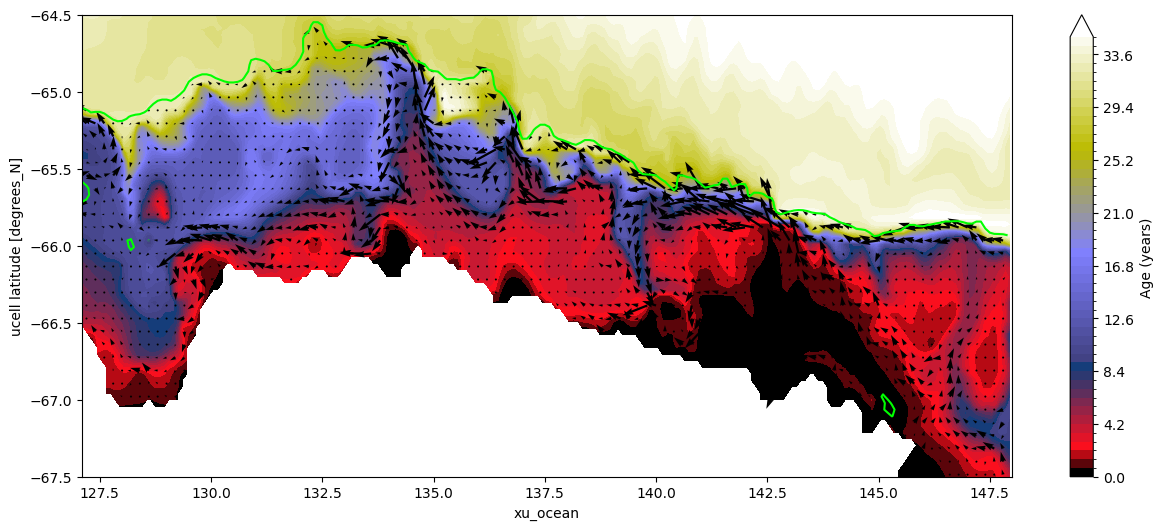

In [27]:
age_bottom.plot.contourf(figsize = (15, 6), vmin = 0, vmax = 35, levels = 51, cmap = 'gist_stern', cbar_kwargs = {'label':'Age (years)'})
bathymetry.plot.contour(levels = [1000], colors = ['lime'])
plt.ylim(-67.5, -64.5); plt.xlim(127.1,148);
plt.quiver(u['xu_ocean'][::2], u['yu_ocean'][::2], 
           u_bottom[::2,::2].where(bathymetry<1000), v_bottom[::2,::2].where(bathymetry<1000));

One of the standout features of the plot above is the Mertz sill, approximately between 140-145E, filled with young, recently ventilated bottom waters. There are other areas with young ages (the blobs at around 134E and 137E), but these are located in shallow shelf regions - which means that the waters do not need to be as dense as those that fill the Mertz sill. 

As we could see in the previous bathymetry plot, the tongues of young water approaching the continental break are located within deep canyons. Shallow bathymetry constrains the younger waters closer to the Antarctic margins. 

Other interesting thing to note is how the velocity contours are aligned with age contours (*little mixing?*). 

## Cross-shelf exchange

The exchanges of water across the shelf are particularly important - specifically how much bottom water gets exported off the shelf (powering the bottom cell of the overturning circulation as Antarctic Bottom Waters) and how much "warm" water gets on the shelf carrying heat towards the Antarctic margins. 

We can calculate these exchanges using the velocity fields and the 1000m isobath. This calculation is complex and takes a lot of time, but if you are interested you can read the COSIMA's recipe [here](https://github.com/COSIMA/cosima-recipes/blob/main/Recipes/Cross-contour_transport.ipynb).

For this tutorial you are provided with the cross shelf volume transports, as well as the temperature and salinity extracted on the 1000m isobath.

In [28]:
transport = xr.open_dataset('data/volume_transport_across_1000m.nc')

This dataset comes with dimensions of depth (`st_ocean`), and dimensions of `contour_index`, where each contour index is associated to a latitude, longitude value. You will notice from the previous plots that the 1000m isobath is not exactly zonally oriented, which is why our spatial coordinate can't simply be longitude.

In [29]:
transport

<xarray.Dataset>
Dimensions:        (st_ocean: 51, time: 228, contour_index: 260)
Coordinates:
  * st_ocean       (st_ocean) float64 0.5413 1.681 2.94 ... 1.333e+03 1.453e+03
  * time           (time) datetime64[ns] 2000-01-16T12:00:00 ... 2018-12-16T1...
  * contour_index  (contour_index) int64 1 2 3 4 5 6 ... 255 256 257 258 259 260
Data variables:
    transport      (time, st_ocean, contour_index) float32 ...
    lat            (contour_index) float64 ...
    lon            (contour_index) float64 ...

Let's plot the transport:

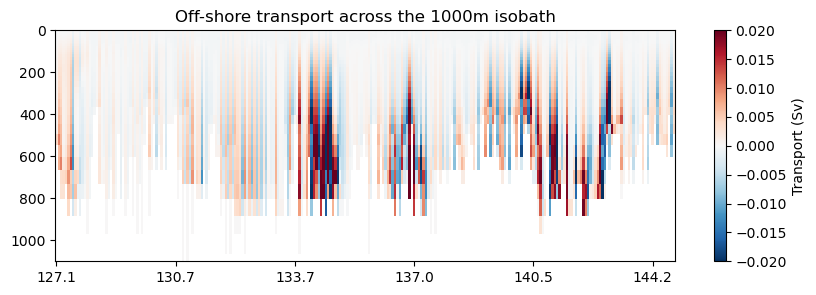

In [30]:
plt.figure(figsize = (10, 3))
plt.pcolormesh(transport['contour_index'], transport['st_ocean'], transport['transport'].mean('time'), vmin = -.02, vmax = .02, cmap = 'RdBu_r');
plt.colorbar().set_label('Transport (Sv)')
plt.title('Off-shore transport across the 1000m isobath')
plt.gca().invert_yaxis()
plt.ylim(1100, None);
plt.xticks(transport['contour_index'][::50], np.round(transport['lon'][::50].values+360, 1));

Large positive values indicate export of waters from the shelf to the open ocean. The plot shows roughly three locations where waters at depth are being exported, which coincide with the canyon regions we've been seeing before. We can integrate to find out exactly how much water (in Sverdrups) is exported below, for example, 600m.

Note how there are alternating patches of red and blue. These are "meanders", where the circulation oscilates around the 1000m isobath. We care about the actual volume that was exported, not that which goes out only to come back in at the next gridcell. For this we integrate cumulatively along the contour index.

In [31]:
export = transport['transport'].sel(st_ocean = slice(600, None)).sum('st_ocean').cumsum('contour_index')

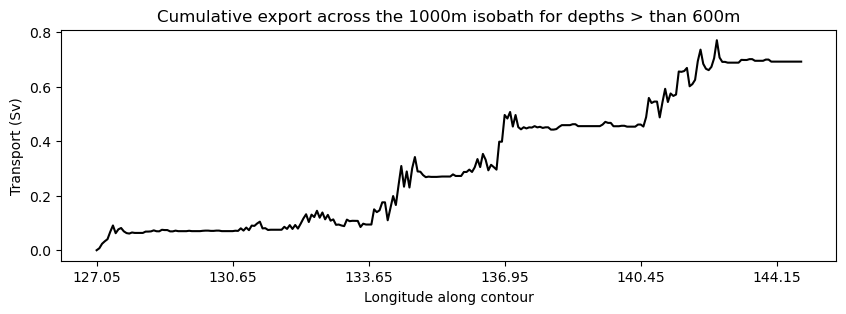

In [32]:
export.mean('time').plot(figsize = (10, 3), c = 'k')
plt.xticks(export['contour_index'][np.arange(0, 300, 50)], 
           np.round(transport['lon'][np.arange(0, 300, 50)].values+360, 2));
plt.xlabel('Longitude along contour')
plt.ylabel('Transport (Sv)')
plt.title('Cumulative export across the 1000m isobath for depths > than 600m');

The above is a cumulative sum: going left to right, when the contour remains constant, there is no export across the 1000m isobath. Where the line starts to grow, we have significant export. Let's isolate those three regions with export, integrate the transport there and get a time series. 

Let's call them from left to right, Canyon 1, Canyon 2 and Canyon 3.

In [33]:
# Latitudes defining the canyon extent
canyon_1_lons = [133.5-360, 135.5-360]
canyon_2_lons = [136-360, 138-360]
canyon_3_lons = [140-360, 143-360]
# Index corresponding to those latitudes
idx_canyon_1 = [np.where(np.abs(transport['lon']-canyon_1_lons[0]) == np.min(np.abs(transport['lon']-canyon_1_lons[0])))[0][0], 
                np.where(np.abs(transport['lon']-canyon_1_lons[1]) == np.min(np.abs(transport['lon']-canyon_1_lons[1])))[0][0]]
idx_canyon_2 = [np.where(np.abs(transport['lon']-canyon_2_lons[0]) == np.min(np.abs(transport['lon']-canyon_2_lons[0])))[0][0], 
                np.where(np.abs(transport['lon']-canyon_2_lons[1]) == np.min(np.abs(transport['lon']-canyon_2_lons[1])))[0][0]]
idx_canyon_3 = [np.where(np.abs(transport['lon']-canyon_3_lons[0]) == np.min(np.abs(transport['lon']-canyon_3_lons[0])))[0][0], 
                np.where(np.abs(transport['lon']-canyon_3_lons[1]) == np.min(np.abs(transport['lon']-canyon_3_lons[1])))[0][0]]

Lets verify we've selected the right bounds:

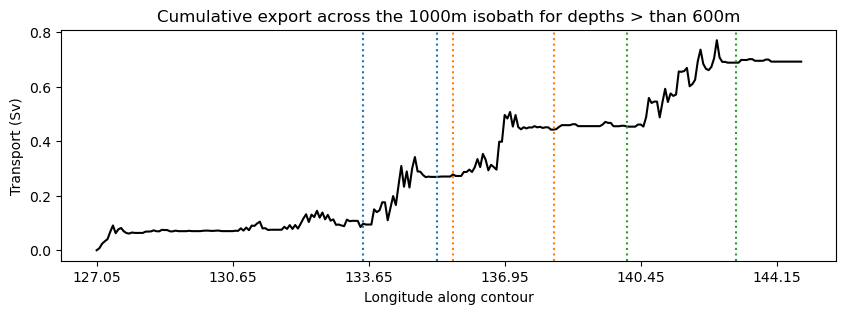

In [34]:
export.mean('time').plot(figsize = (10, 3), c = 'k')
plt.xticks(export['contour_index'][np.arange(0, 300, 50)], 
           np.round(transport['lon'][np.arange(0, 300, 50)].values+360, 2));
plt.xlabel('Longitude along contour')
plt.ylabel('Transport (Sv)')
plt.title('Cumulative export across the 1000m isobath for depths > than 600m');
plt.axvline(x = transport['contour_index'][idx_canyon_1[0]], linestyle = ':', color = 'C0')
plt.axvline(x = transport['contour_index'][idx_canyon_1[1]], linestyle = ':', color = 'C0')
plt.axvline(x = transport['contour_index'][idx_canyon_2[0]], linestyle = ':', color = 'C1')
plt.axvline(x = transport['contour_index'][idx_canyon_2[1]], linestyle = ':', color = 'C1')
plt.axvline(x = transport['contour_index'][idx_canyon_3[0]], linestyle = ':', color = 'C2')
plt.axvline(x = transport['contour_index'][idx_canyon_3[1]], linestyle = ':', color = 'C2');

In [35]:
export_canyon_1 = transport['transport'].sel(st_ocean = slice(600, None)).isel(contour_index = slice(idx_canyon_1[0], idx_canyon_1[1])).sum(['st_ocean', 'contour_index'])
export_canyon_2 = transport['transport'].sel(st_ocean = slice(600, None)).isel(contour_index = slice(idx_canyon_2[0], idx_canyon_2[1])).sum(['st_ocean', 'contour_index'])
export_canyon_3 = transport['transport'].sel(st_ocean = slice(600, None)).isel(contour_index = slice(idx_canyon_3[0], idx_canyon_3[1])).sum(['st_ocean', 'contour_index'])

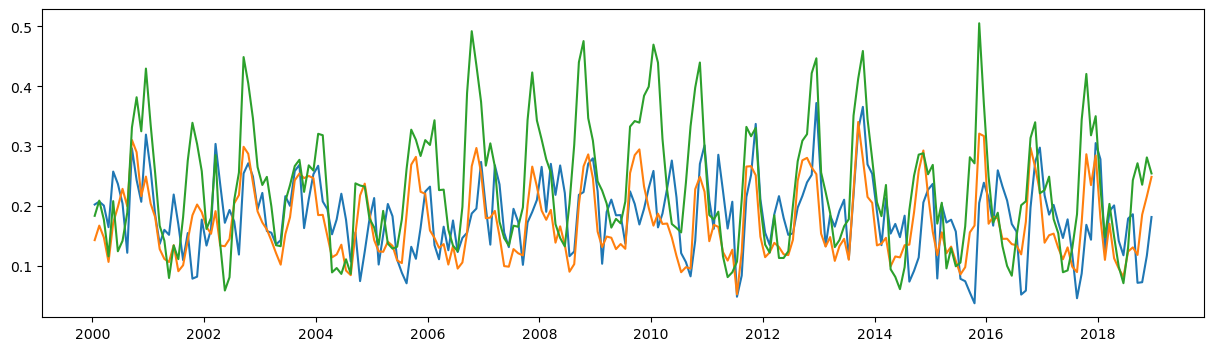

In [36]:
plt.figure(figsize = (15, 4))
plt.plot(export_canyon_1['time'], export_canyon_1)
plt.plot(export_canyon_2['time'], export_canyon_2)
plt.plot(export_canyon_3['time'], export_canyon_3)

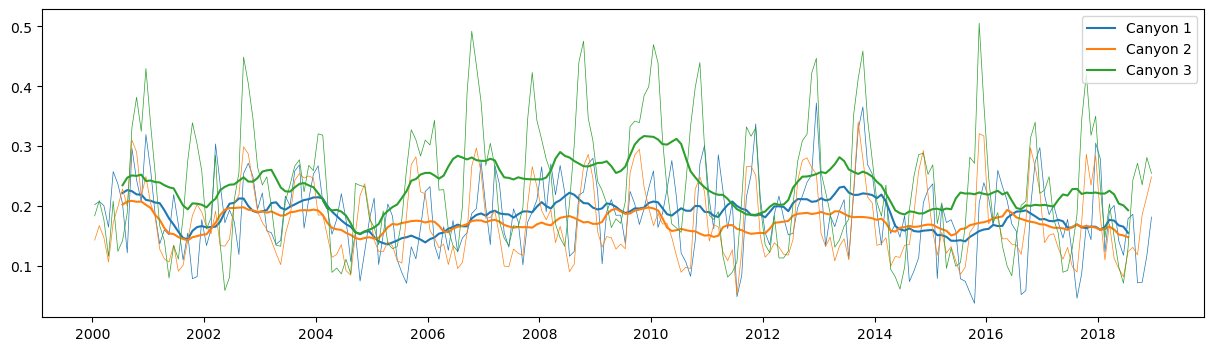

In [37]:
plt.figure(figsize = (15, 4))
plt.plot(export_canyon_1['time'], export_canyon_1, c = 'C0', linewidth = 0.5)
plt.plot(export_canyon_1['time'], export_canyon_1.rolling(time = 12, center = True).mean('time'), c = 'C0', linewidth = 1.5, label = 'Canyon 1')
plt.plot(export_canyon_2['time'], export_canyon_2, c = 'C1', linewidth = 0.5)
plt.plot(export_canyon_2['time'], export_canyon_2.rolling(time = 12, center = True).mean('time'), c = 'C1', linewidth = 1.5, label = 'Canyon 2')
plt.plot(export_canyon_3['time'], export_canyon_3, c = 'C2', linewidth = 0.5)
plt.plot(export_canyon_3['time'], export_canyon_3.rolling(time = 12, center = True).mean('time'), c = 'C2', linewidth = 1.5, label = 'Canyon 3');
plt.legend();

Canyon 3 is the one with the most vigorous export, and with the largest variability of them all. The other two exports seem to vary less (and in phase). We can calculate the properties of these exports too (temperature salinity)

In [38]:
temp_salt_export = xr.open_dataset('data/salt_temp_slope.nc')
temp_salt_export

<xarray.Dataset>
Dimensions:        (st_ocean: 51, time: 228, contour_index: 192)
Coordinates:
  * st_ocean       (st_ocean) float64 0.5413 1.681 2.94 ... 1.333e+03 1.453e+03
  * time           (time) datetime64[ns] 2000-01-16T12:00:00 ... 2018-12-16T1...
  * contour_index  (contour_index) int64 1 2 3 4 5 6 ... 187 188 189 190 191 192
Data variables:
    temp           (time, st_ocean, contour_index) float64 ...
    salt           (time, st_ocean, contour_index) float64 ...
    lat            (contour_index) float64 ...
    lon            (contour_index) float64 ...

This might be a bit technical, **but**, the `contour_index` dimension is not the same for the export data as for the temp, salt data. This is because the model works on a staggered grid, where the velocities and other vectors are evaluated in the corner of gridcells, whereas temperature, salinity and other tracers are evaluated at cell centers. This means their dimensions are slightly different.

In [39]:
# Index corresponding to those latitudes
idx_canyon_1 = [np.where(np.abs(temp_salt_export['lon']-canyon_1_lons[0]) == np.min(np.abs(temp_salt_export['lon']-canyon_1_lons[0])))[0][0], 
                np.where(np.abs(temp_salt_export['lon']-canyon_1_lons[1]) == np.min(np.abs(temp_salt_export['lon']-canyon_1_lons[1])))[0][0]]
idx_canyon_2 = [np.where(np.abs(temp_salt_export['lon']-canyon_2_lons[0]) == np.min(np.abs(temp_salt_export['lon']-canyon_2_lons[0])))[0][0], 
                np.where(np.abs(temp_salt_export['lon']-canyon_2_lons[1]) == np.min(np.abs(temp_salt_export['lon']-canyon_2_lons[1])))[0][0]]
idx_canyon_3 = [np.where(np.abs(temp_salt_export['lon']-canyon_3_lons[0]) == np.min(np.abs(temp_salt_export['lon']-canyon_3_lons[0])))[0][0], 
                np.where(np.abs(temp_salt_export['lon']-canyon_3_lons[1]) == np.min(np.abs(temp_salt_export['lon']-canyon_3_lons[1])))[0][0]]

In [40]:
temp_canyon_1 = temp_salt_export['temp'].sel(st_ocean = slice(600, None)).isel(contour_index = slice(idx_canyon_1[0], idx_canyon_1[1])).mean(['st_ocean', 'contour_index'])-273.15
temp_canyon_2 = temp_salt_export['temp'].sel(st_ocean = slice(600, None)).isel(contour_index = slice(idx_canyon_2[0], idx_canyon_2[1])).mean(['st_ocean', 'contour_index'])-273.15
temp_canyon_3 = temp_salt_export['temp'].sel(st_ocean = slice(600, None)).isel(contour_index = slice(idx_canyon_3[0], idx_canyon_3[1])).mean(['st_ocean', 'contour_index'])-273.15

In [41]:
salt_canyon_1 = temp_salt_export['salt'].sel(st_ocean = slice(600, None)).isel(contour_index = slice(idx_canyon_1[0], idx_canyon_1[1])).mean(['st_ocean', 'contour_index'])
salt_canyon_2 = temp_salt_export['salt'].sel(st_ocean = slice(600, None)).isel(contour_index = slice(idx_canyon_2[0], idx_canyon_2[1])).mean(['st_ocean', 'contour_index'])
salt_canyon_3 = temp_salt_export['salt'].sel(st_ocean = slice(600, None)).isel(contour_index = slice(idx_canyon_3[0], idx_canyon_3[1])).mean(['st_ocean', 'contour_index'])

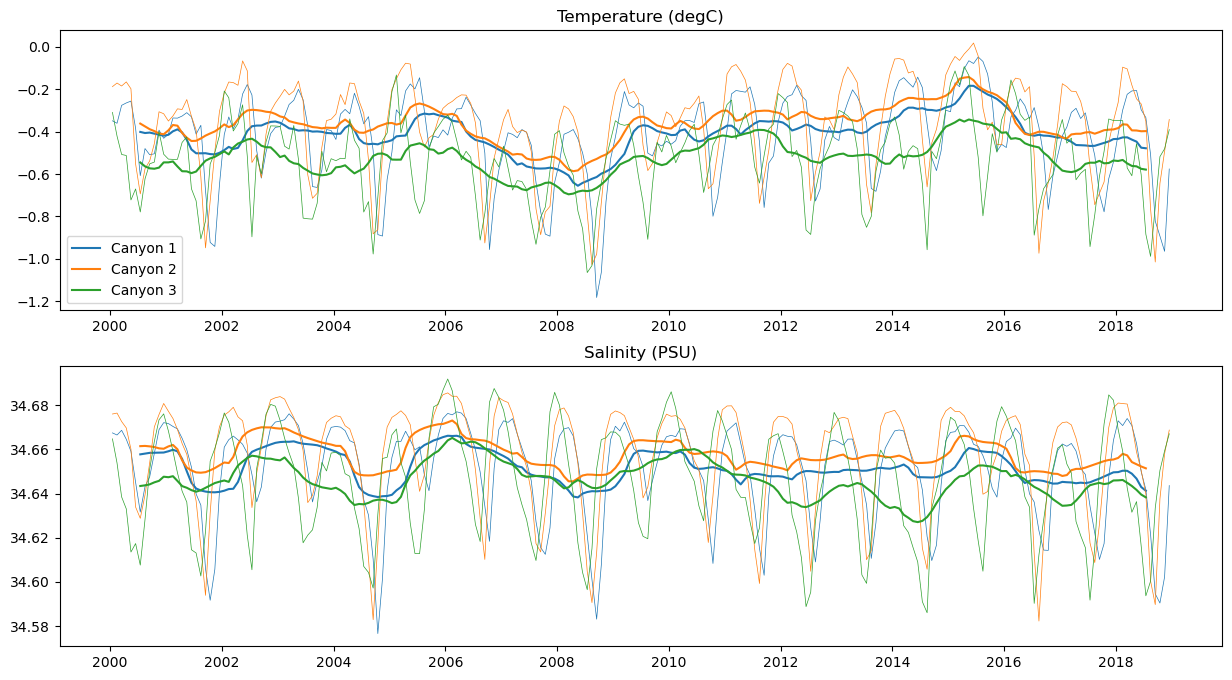

In [42]:
fig, axs = plt.subplots(2, 1, figsize = (15, 8))
axs[0].plot(temp_canyon_1['time'], temp_canyon_1, c = 'C0', linewidth = 0.5)
axs[0].plot(temp_canyon_1['time'], temp_canyon_1.rolling(time = 12, center = True).mean('time'), c = 'C0', linewidth = 1.5, label = 'Canyon 1')
axs[0].plot(temp_canyon_2['time'], temp_canyon_2, c = 'C1', linewidth = 0.5)
axs[0].plot(temp_canyon_2['time'], temp_canyon_2.rolling(time = 12, center = True).mean('time'), c = 'C1', linewidth = 1.5, label = 'Canyon 2')
axs[0].plot(temp_canyon_3['time'], temp_canyon_3, c = 'C2', linewidth = 0.5)
axs[0].plot(temp_canyon_3['time'], temp_canyon_3.rolling(time = 12, center = True).mean('time'), c = 'C2', linewidth = 1.5, label = 'Canyon 3');
axs[0].set_title('Temperature (degC)')
axs[0].legend();

axs[1].plot(salt_canyon_1['time'], salt_canyon_1, c = 'C0', linewidth = 0.5)
axs[1].plot(salt_canyon_1['time'], salt_canyon_1.rolling(time = 12, center = True).mean('time'), c = 'C0', linewidth = 1.5, label = 'Canyon 1')
axs[1].plot(salt_canyon_2['time'], salt_canyon_2, c = 'C1', linewidth = 0.5)
axs[1].plot(salt_canyon_2['time'], salt_canyon_2.rolling(time = 12, center = True).mean('time'), c = 'C1', linewidth = 1.5, label = 'Canyon 2')
axs[1].plot(salt_canyon_3['time'], salt_canyon_3, c = 'C2', linewidth = 0.5)
axs[1].plot(salt_canyon_3['time'], salt_canyon_3.rolling(time = 12, center = True).mean('time'), c = 'C2', linewidth = 1.5, label = 'Canyon 3');
axs[1].set_title('Salinity (PSU)');

# Key takeaways

 - We had a lot more variables to characterise this region in the model (3D fields of velocity, age, etc), which allow for a lot more analysis than the shipboard observations (point-wise CTD profiles, etc).
 - However, like the I09S notebook showed, the model is subject to biases, and it is hard to contraint its "accuracy" in such a poorly observed region. 
 - Therefore, the results should **not** be taken as the absolute truth. It is very important to understand what the model can/can not do. Amongst the things it cannot do (as most other global models), is accurately represent ice shelves and their interaction with the surrounding ocean. In the Antarctic margins, this representation is extremely important - so we need to keep in mind it is missing here. 
 - **Write any other points you wish to discuss in the class. Maybe if Kaihe's paper is already published link it to that.**